<h1>Analyze the data and provide target variables for the model</h1>

The goal of this notebook is to analyze the 1h candles data on BTCUSDT trading pair, find if it has any dependencies and test is it possible to predict the price movement up or down with ski-learn models.

In [5]:
# Importing the dataset
import pandas as pd
dataset = pd.read_csv('../data/BTCUSDT-1h.csv')
dataset.head()

,open_time,open,high,low,close,volume,num_trades,taker_base_vol
0,1541318400000,6388.33,6410.00,6387.00,6408.09,340.668603,4923,208.962466
1,1541322000000,6408.66,6415.47,6391.14,6393.12,445.966896,5608,206.470628
2,1541325600000,6393.12,6399.16,6388.10,6398.88,259.283332,4537,126.768854
3,1541329200000,6398.88,6414.81,6394.84,6402.54,292.980683,4689,154.843012
4,1541332800000,6403.96,6413.00,6402.00,6404.89,320.635364,4870,132.643557


In [6]:
# Provide columns up (difference between open and high in percentage) and down (difference between open and low in percentage)
dataset['up'] = (dataset['high'] - dataset['open']) / dataset['open'] * 100
dataset['down'] = (dataset['open'] - dataset['low']) / dataset['open'] * 100
dataset.head()

,open_time,open,high,low,close,volume,num_trades,taker_base_vol,up,down
0,1541318400000,6388.33,6410.00,6387.00,6408.09,340.668603,4923,208.962466,0.339212,0.020819
1,1541322000000,6408.66,6415.47,6391.14,6393.12,445.966896,5608,206.470628,0.106262,0.273380
2,1541325600000,6393.12,6399.16,6388.10,6398.88,259.283332,4537,126.768854,0.094477,0.078522
3,1541329200000,6398.88,6414.81,6394.84,6402.54,292.980683,4689,154.843012,0.248950,0.063136
4,1541332800000,6403.96,6413.00,6402.00,6404.89,320.635364,4870,132.643557,0.141163,0.030606


In [11]:
"Average up and down", dataset['up'].mean(), dataset['down'].mean(), "Median up and down", dataset['up'].median(), dataset['down'].median()

('Average up and down',
 0.47432651905316536,
 0.49966946544944074,
 'Median up and down',
 0.298491911159859,
 0.3048219955186234)

Let's see how many times the price went up and down with gistogram

C:\Users\Admin\AppData\Local\Temp\ipykernel_5220\887820371.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset['up'], bins=100)


<Axes: xlabel='up', ylabel='Density'>

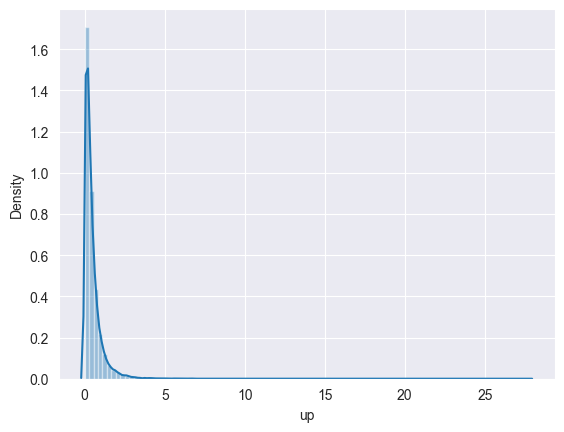

In [9]:
import seaborn as sns
sns.distplot(dataset['up'], bins=100)

C:\Users\Admin\AppData\Local\Temp\ipykernel_5220\3373600533.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset['down'], bins=100)


<Axes: xlabel='down', ylabel='Density'>

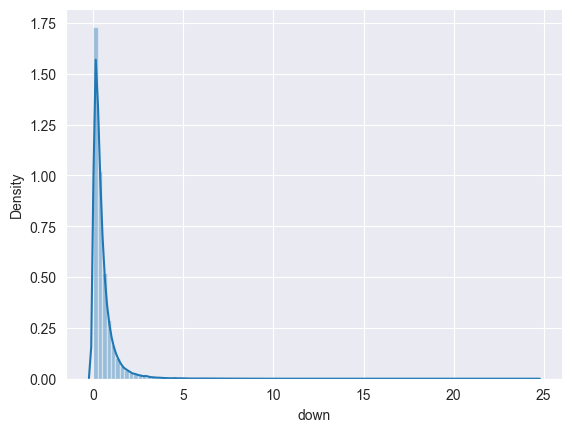

In [10]:
sns.distplot(dataset['down'], bins=100)

Let's deside how many times the price moves more or equal than 1.1% up and down
Why so?
Because commission is 0.1% and I want to make profit at least 1%. So I need to move more than 1.1% up or down to have small profit at least.

In [16]:
ups = dataset[dataset['up'] >= 1.1]
downs = dataset[dataset['down'] >= 1.1]
"Ups", len(ups), f"{len(ups)/len(dataset)*100:.2f}%", "Downs", len(downs), f"{len(downs)/len(dataset)*100:.2f}%"

('Ups', 4065, '9.29%', 'Downs', 4502, '10.29%')

So approximately 20% of the time the price moves more than 1.1% up or down, which is good.
We are looking on 1h candles, so we can make average 4-5 trades per day. =)
Oh this goddamn commission and statistic 

So let's add new dummy columns represents our three states: 
1. <b>long</b> for going price up for 1.1% or more
2. <b>flat</b> when price not went up or down for 1.1%
3. <b>short</b> for going price down for 1.1% or more 

In [20]:
dataset["long"] = (dataset["up"] >= 1.1).astype(int)
dataset["flat"] = ((dataset["up"] <= 1.1) & (dataset["down"] <= 1.1)).astype(int)
dataset["short"] = (dataset["down"] >= 1.1).astype(int)
dataset.head()

,open_time,open,high,low,close,volume,num_trades,taker_base_vol,up,down,long,flat,short
0,1541318400000,6388.33,6410.00,6387.00,6408.09,340.668603,4923,208.962466,0.339212,0.020819,0,1,0
1,1541322000000,6408.66,6415.47,6391.14,6393.12,445.966896,5608,206.470628,0.106262,0.273380,0,1,0
2,1541325600000,6393.12,6399.16,6388.10,6398.88,259.283332,4537,126.768854,0.094477,0.078522,0,1,0
3,1541329200000,6398.88,6414.81,6394.84,6402.54,292.980683,4689,154.843012,0.248950,0.063136,0,1,0
4,1541332800000,6403.96,6413.00,6402.00,6404.89,320.635364,4870,132.643557,0.141163,0.030606,0,1,0


In [22]:
# Drop open_time, up, down columns
dataset.drop(columns=['open_time', 'up', 'down'], inplace=True)
# Shift targets (long, flat, short) for prediction and drop nulls
dataset['long'] = dataset['long'].shift(-1)
dataset['flat'] = dataset['flat'].shift(-1)
dataset['short'] = dataset['short'].shift(-1)
dataset.dropna(inplace=True)
dataset.head()

,open,high,low,close,volume,num_trades,taker_base_vol,long,flat,short
0,6388.33,6410.00,6387.00,6408.09,340.668603,4923,208.962466,0.0,1.0,0.0
1,6408.66,6415.47,6391.14,6393.12,445.966896,5608,206.470628,0.0,1.0,0.0
2,6393.12,6399.16,6388.10,6398.88,259.283332,4537,126.768854,0.0,1.0,0.0
3,6398.88,6414.81,6394.84,6402.54,292.980683,4689,154.843012,0.0,1.0,0.0
4,6403.96,6413.00,6402.00,6404.89,320.635364,4870,132.643557,0.0,1.0,0.0


Now let's try to find some dependencies

<Axes: >

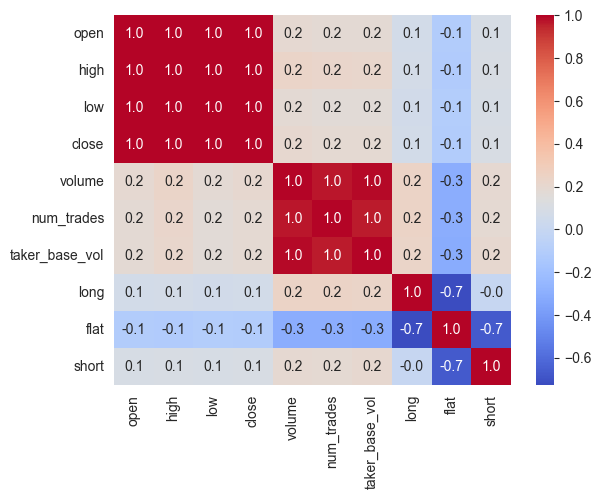

In [28]:
# Trying to find different correlations with heatmap
sns.heatmap(dataset.tail(1000).corr(), annot = True, fmt=".1f", cmap= 'coolwarm')

The best correlation, despite all 'ones' is between flat and volumes/number of trades

<h1>Prepare data for model</h1>

In [29]:
# Split dataset to X and y
X = dataset.iloc[:, :-3].values
y = dataset.iloc[:, -3:].values

# Split dataset to train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Scale features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [30]:
# Check shapes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((35004, 7), (8752, 7), (35004, 3), (8752, 3))

<h1>Describe and train models</h1>

Here we will try to train different models and compare their results